# Generate figures for the paper

Cumulative emissions, peaking and projected median warming over time as countries submitted nationally determined contributions



In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [26]:
import datetime as dt
import logging
import os.path

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import scmdata
import seaborn as sns
from datetime import datetime

from matplotlib.path import Path
from matplotlib.patches import PathPatch

from ndcs.constants import PROCESSED_DATA_DIR, NDC_TARGET_RELEASE, ROOT_DATA_DIR


<IPython.core.display.Javascript object>

In [4]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams["text.usetex"] = False
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 8

<IPython.core.display.Javascript object>

### read in Country submission dates. 

In [5]:
pathway_countries_fn = os.path.join(
    PROCESSED_DATA_DIR, "{}_pathway_countries.csv".format(NDC_TARGET_RELEASE)
)
pathway_countries_fn

'/home/jared/code/cr/ndc-realisations-2021/src/ndcs/../../data/processed/12Nov2021a_CR_pathway_countries.csv'

<IPython.core.display.Javascript object>

In [6]:
country_submission_dates = pd.read_csv(pathway_countries_fn)
country_submission_dates

,pathway_id,last_country
0,2013-07-18_1,LBY
1,2013-07-18_2,ZZA
2,2013-07-18_3,ZZB
3,2015-08-05_1,MKD
4,2015-09-26_1,SEN
5,2015-09-30_1,SMR
6,2015-09-30_2,TUR
7,2015-10-01_1,MOZ
8,2015-10-01_2,PHL
9,2015-11-12_1,IRQ


<IPython.core.display.Javascript object>

## Configuration

In [7]:
DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "climate_assessment", "merged")
OUT_FNAME = os.path.join(DATA_DIR, f"output_{NDC_TARGET_RELEASE}_complete.csv")

<IPython.core.display.Javascript object>

# Preprocessing

In [8]:
all_output = scmdata.ScmRun(OUT_FNAME).filter(
    conditionality=["C", "U"], exclude_hot_air="exclude", country_extension="SSP1BL"
)

<IPython.core.display.Javascript object>

In [9]:
all_output.get_unique_meta("variable")

['Atmospheric Concentrations|CH4|MAGICCv7.5.3',
 'Atmospheric Concentrations|CO2|MAGICCv7.5.3',
 'Atmospheric Concentrations|N2O|MAGICCv7.5.3',
 'Effective Radiative Forcing|Aerosols|Direct Effect|BC|MAGICCv7.5.3',
 'Effective Radiative Forcing|Aerosols|Direct Effect|MAGICCv7.5.3',
 'Effective Radiative Forcing|Aerosols|Direct Effect|OC|MAGICCv7.5.3',
 'Effective Radiative Forcing|Aerosols|Direct Effect|Sulfur|MAGICCv7.5.3',
 'Effective Radiative Forcing|Aerosols|Indirect Effect|MAGICCv7.5.3',
 'Effective Radiative Forcing|Aerosols|MAGICCv7.5.3',
 'Effective Radiative Forcing|Basket|Anthropogenic|MAGICCv7.5.3',
 'Effective Radiative Forcing|Basket|Greenhouse Gases|MAGICCv7.5.3',
 'Effective Radiative Forcing|Basket|Non-CO2 Anthropogenic|MAGICCv7.5.3',
 'Effective Radiative Forcing|Basket|Non-CO2 Greenhouse Gases|MAGICCv7.5.3',
 'Effective Radiative Forcing|C2F6|MAGICCv7.5.3',
 'Effective Radiative Forcing|C6F14|MAGICCv7.5.3',
 'Effective Radiative Forcing|CF4|MAGICCv7.5.3',
 'Effective

<IPython.core.display.Javascript object>

In [10]:
median_warming = all_output.filter(
    variable="Surface Temperature (GSAT)|MAGICCv7.5.3", quantile=0.5
)
ghg_emissions = all_output.filter(
    variable='Infilled|Emissions|Kyoto Gases (AR6-GWP100)'
)
co2_emissions = all_output.filter(variable='Infilled|Emissions|CO2|AFOLU').add(
    all_output.filter(variable='Infilled|Emissions|CO2|Energy and Industrial Processes'), 
    op_cols={"variable": "Emissions|CO2"}
).filter(year=range(2015, 2101))


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='K'>

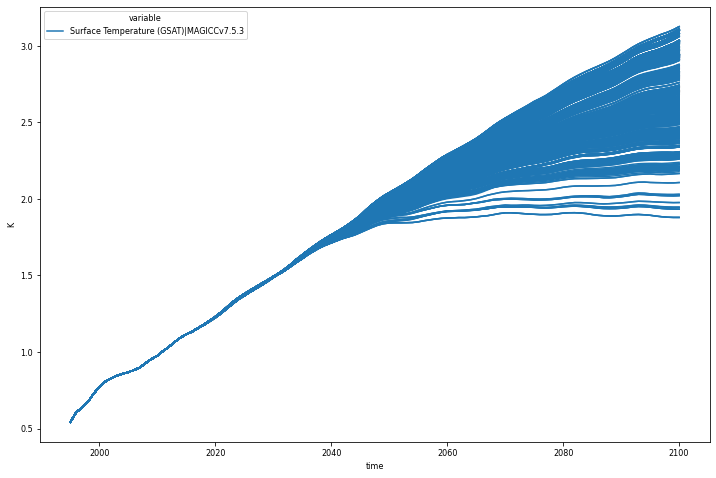

<IPython.core.display.Javascript object>

In [11]:
median_warming.lineplot(hue="variable", units="scenario", estimator=None)

In [17]:
from openscm_units import unit_registry


# This will be available in a future scmdata release
def cumsum(self, out_var=None, check_annual=True):
    """
    Integrate with respect to time using a cumulative sum

    This method should be used when dealing with piecewise-constant timeseries (
    such as annual emissions) or step functions. In the case of annual emissions,
    each timestep represents a total flux over a whole year, rather than an
    average value or point in time estimate. When integrating, one
    can sum up each individual year to get the cumulative total, rather than using
    an alternative method for numerical integration, such as the trapizoidal
    rule which assumes that the values change linearly between timesteps.

    This method requires data to be on uniform annual intervals.
    :meth:`scmdata.run.ScmRun.resample` can be used to resample the data onto
    annual timesteps.

    The output timesteps are the same as the timesteps of the input, but since the
    input timeseries are piecewise constant (i.e. a constant for a given year),
    the output can also be thought of as being a sum up to and including the last day
    of a given year. The functionality to modify the output timesteps to an
    arbitrary day/month of the year has not been implemented, if that would be
    useful raise an issue on GitHub.

    If the timeseries are piecewise-linear, :meth:`cumtrapz` should be used instead.

    Parameters
    ----------
    out_var : str
        If provided, the variable column of the output is set equal to
        ``out_var``. Otherwise, the output variables are equal to the input
        variables, prefixed with "Cumulative ".

    check_annual : bool
        If True (default), check that the timeseries are on uniform annual
        intervals.

    Returns
    -------
    :class:`scmdata.ScmRun <scmdata.run.ScmRun>`
        :class:`scmdata.ScmRun <scmdata.run.ScmRun>` containing the integral of ``self`` with respect
        to time

    See Also
    --------
    :func:`cumtrapz`

    Raises
    ------
    ValueError
        If an unknown method is provided
        Failed unit conversion
        Non-annual timeseries and `check_annual` is True

    Warns
    -----
    UserWarning
        The data being integrated contains nans. If this happens, the output
        data will also contain nans.

    """
    time_unit = "a"

    if self.timeseries().isnull().sum().sum() > 0:
        warnings.warn(
            "You are integrating data which contains nans so your result will "
            "also contain nans. Perhaps you want to remove the nans before "
            "performing the integration using a combination of :meth:`filter` "
            "and :meth:`interpolate`?"
        )

    # Check that all intervals are uniform and equal
    years = self["year"]
    if check_annual and not (years.diff().iloc[1:] == 1).all():
        raise ValueError(
            'Annual data are required for "cumsum" integration. Use ScmRun.resample first'
        )

    ts = self.timeseries()

    out = ts.cumsum(skipna=False, axis=1)
    out.index = ts.index
    out.columns = ts.columns

    out = type(self)(out)
    out *= unit_registry(time_unit)

    try:
        u = out.get_unique_meta("unit", no_duplicates=True).replace(" ", "")
        u = str(unit_registry(u).to_reduced_units().units)
        out = out.convert_unit(u)
    except ValueError:
        # more than one unit, don't try to clean up
        pass

    if out_var is None:
        out["variable"] = "Cumulative " + out["variable"]
    else:
        out["variable"] = out_var

    return out

<IPython.core.display.Javascript object>

In [18]:
def calc_cum_emms(emissions, zero_year=2019, unit="Gt CO2"):
    cum_emissions = (
        cumsum(
            emissions,
        )
        .relative_to_ref_period_mean(year=zero_year)
        .convert_unit(unit)
    )

    return cum_emissions


cum_co2_emissions = calc_cum_emms(co2_emissions)

<IPython.core.display.Javascript object>

In [19]:
cum_co2_emissions.head()

time                                                                                                                                                                                                                                               2015-01-01  \
ambition conditionality country_extension exclude_hot_air methane_pledges model         pathway_id   quantile reference_period_end_year reference_period_start_year region scenario                               unit   variable                               
high     C              SSP1BL            exclude         NaN             NDC Factsheet 2013-07-18_1 NaN      2019                      2019                        World  2013-07-18_1__high__C__SSP1BL__exclude Gt CO2 Cumulative Emissions|CO2 -162.662041   
         U              SSP1BL            exclude         NaN             NDC Factsheet 2013-07-18_1 NaN      2019                      2019                        World  2013-07-18_1__high__U__SSP1BL__exclude Gt CO2 Cumulative Emissions|CO2 -162.662041   
low      C              SSP1BL            exclude         NaN             NDC Factsheet 2013-07-18_1 NaN      2019                      2019                        World  2013-07-18_1__low__C__SSP1BL__exclude  Gt CO2 Cumulative Emissions|CO2 -162.662041   
         U              SSP1BL            exclude         NaN             NDC Factsheet 2013-07-18_1 NaN      2019                      2019                        World  2013-07-18_1__low__U__SSP1BL__exclude  Gt CO2 Cumulative Emissions|CO2 -162.662041   
high     C              SSP1BL            exclude         NaN             NDC Factsheet 2013-07-18_2 NaN      2019                      2019                        World  2013-07-18_2__high__C__SSP1BL__exclude Gt CO2 Cumulative Emissions|CO2 -162.760242   

time                                                                                                                                                                                                                                               2016-01-01  \
ambition conditionality country_extension exclude_hot_air methane_pledges model         pathway_id   quantile reference_period_end_year reference_period_start_year region scenario                               unit   variable                               
high     C              SSP1BL            exclude         NaN             NDC Factsheet 2013-07-18_1 NaN      2019                      2019                        World  2013-07-18_1__high__C__SSP1BL__exclude Gt CO2 Cumulative Emissions|CO2 -122.685102   
         U              SSP1BL            exclude         NaN             NDC Factsheet 2013-07-18_1 NaN      2019                      2019                        World  2013-07-18_1__high__U__SSP1BL__exclude Gt CO2 Cumulative Emissions|CO2 -122.685102   
low      C              SSP1BL            exclude         NaN             NDC Factsheet 2013-07-18_1 NaN      2019                      2019                        World  2013-07-18_1__low__C__SSP1BL__exclude  Gt CO2 Cumulative Emissions|CO2 -122.685102   
         U              SSP1BL            exclude         NaN             NDC Factsheet 2013-07-18_1 NaN      2019                      2019                        World  2013-07-18_1__low__U__SSP1BL__exclude  Gt CO2 Cumulative Emissions|CO2 -122.685102   
high     C              SSP1BL            exclude         NaN             NDC Factsheet 2013-07-18_2 NaN      2019                      2019                        World  2013-07-18_2__high__C__SSP1BL__exclude Gt CO2 Cumulative Emissions|CO2 -122.773491   

time                                                                                                                                                                                                                                               2017-01-01  \
ambition conditionality country_extension exclude_hot_air methane_pledges model         pathway_id   quantile reference_period_end_year referen

<IPython.core.display.Javascript object>

In [20]:
data_of_interest = scmdata.run_append(
    [median_warming, cum_co2_emissions, ghg_emissions]
)

<IPython.core.display.Javascript object>

In [22]:
# Lets make a big table of scenarios and their statistics

data = []
for group in data_of_interest.groupby("scenario"):
    scenario = group.get_unique_meta("scenario", True)
    
    date_str, ambition, conditionality, extension, hot_air = scenario.split("__")
    
    if (hot_air == "include"):
        continue
    
    date_only, idx = date_str.split("_")
    date = datetime.strptime(date_only, "%Y-%m-%d")
    
    warming = group.filter(variable="Surface Temperature (GSAT)|MAGICCv7.5.3", quantile=0.5)
    peak_temperature = warming.values.max().squeeze()
    eoc_temperature = float(warming.filter(year=2100).values.squeeze())
    
    cum_co2 = group.filter(variable="Cumulative Emissions|CO2")
    
    ghg = group.filter(variable='Infilled|Emissions|Kyoto Gases (AR6-GWP100)')
    
    
    data.append({
        "pathway_id": date_str,
        "date": date,
        "day_index": idx,
        "ambition": ambition,
        "conditionality": conditionality,
        "extension": extension,
        "hot_air": hot_air,
        "eoc_warming": eoc_temperature,
        "peak_warming": peak_temperature,
        "cum_co2_2020-2030": float(cum_co2.filter(year=2030).values.squeeze()),
        "cum_co2_2020-2050": float(cum_co2.filter(year=2050).values.squeeze()),
        "ghg_diff_2025-2030": ghg.filter(year=2025).values.squeeze() - ghg.filter(year=2030).values.squeeze(),
        
    })
    


<IPython.core.display.Javascript object>

In [23]:
df = pd.DataFrame(data).sort_values("date")
df = df[df.date.dt.year >= 2015]
df = df.merge(country_submission_dates, right_on="pathway_id", left_on="pathway_id")
df["day_index"] = df["day_index"].astype(int)

<IPython.core.display.Javascript object>

In [24]:
df["conditionality"].unique()

array(['C', 'U'], dtype=object)

<IPython.core.display.Javascript object>

<AxesSubplot:>

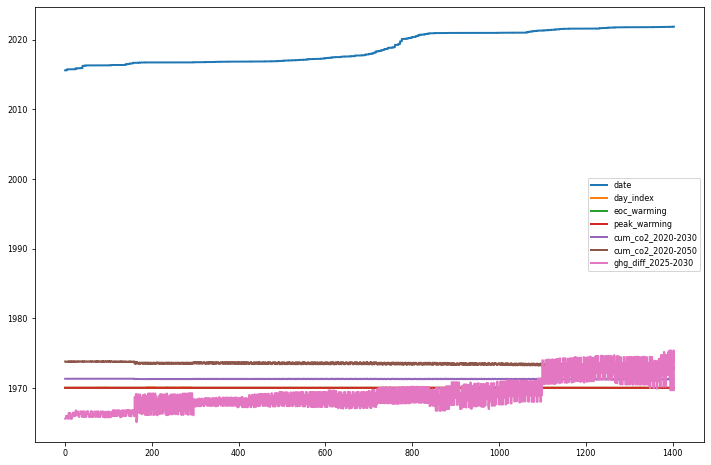

<IPython.core.display.Javascript object>

In [25]:
df.plot(drawstyle="steps-post", linewidth=2)

In [21]:
def find_steps(selected_items, variable, sensitivity):
    diffs = selected_items[variable].diff(periods=1)
    big_change_rows = abs(diffs) > sensitivity

    return pd.merge(
        selected_items[big_change_rows],
        diffs[big_change_rows],
        left_index=True,
        right_index=True,
        suffixes=("", "_diff"),
    ).reset_index()


def plot_steps(ambition, conditionality, variable, ax, sensitivity=0.4):
    df_subsample = (
        df[
            (df["ambition"] == ambition)
            & (df["conditionality"] == conditionality)
            & (df["hot_air"] == "exclude")
        ]
        .sort_values(["date", "day_index"])
        .set_index(["date", "last_country"])
    )

    diffs = find_steps(df_subsample, variable, sensitivity)

    for item in diffs.to_dict("records"):
        ax.text(item["date"], item[variable], item["last_country"])

<IPython.core.display.Javascript object>

In [22]:
df_subsample = (
    df[
        (df["ambition"] == "low")
        & (df["conditionality"] == "C")
        & (df["hot_air"] == "exclude")
    ]
    .sort_values(["date", "day_index"])
    .set_index(["date", "last_country"])
)

find_steps(df_subsample, "peak_warming", 0.04)

,date,last_country,pathway_id,day_index,ambition,conditionality,extension,hot_air,eoc_warming,peak_warming,cum_co2_2020-2030,cum_co2_2020-2050,ghg_diff_2025-2030,peak_warming_diff
0,2016-09-03,CHN,2016-09-03_1,1,low,C,SSP1BL,exclude,3.015387,3.015387,469.766386,1349.667921,-1630.394224,-0.045329
1,2016-09-03,USA,2016-09-03_2,2,low,C,SSP1BL,exclude,2.915259,2.915259,466.102058,1313.728061,-1163.448262,-0.100129
2,2016-10-02,IND,2016-10-02_1,1,low,C,SSP1BL,exclude,2.965504,2.965504,472.611748,1336.014193,-666.718052,0.053898
3,2016-11-08,JPN,2016-11-08_1,1,low,C,SSP1BL,exclude,2.874189,2.874189,470.024346,1313.418770,-510.149489,-0.043136
4,2018-04-30,ZZB,2018-04-30_1,1,low,C,SSP1BL,exclude,2.616256,2.616256,467.741807,1280.987281,-49.037934,-0.165495
5,2020-12-09,BRA,2020-12-09_1,1,low,C,SSP1BL,exclude,2.546572,2.546572,468.787463,1268.836884,-382.110321,-0.042111
6,2021-04-22,USA,2021-04-22_1,1,low,C,SSP1BL,exclude,2.382729,2.382729,462.488417,1208.569205,1085.321288,-0.066235
7,2021-10-28,CHN,2021-10-28_2,2,low,C,SSP1BL,exclude,2.106667,2.109830,454.216186,1095.824501,1883.063094,-0.169581
8,2021-11-01,IND,2021-11-01_1,1,low,C,SSP1BL,exclude,1.946532,1.960236,449.129014,1045.452614,1321.672484,-0.149592


<IPython.core.display.Javascript object>

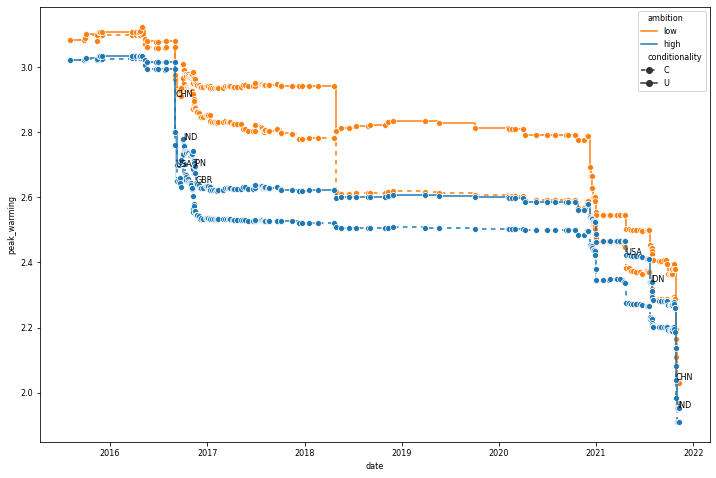

<IPython.core.display.Javascript object>

In [23]:
palette = {"high": "tab:blue", "low": "tab:orange", "U": "tab:grey", "C": "tab:blue"}

dashes = {"C": (3, 3), "U": ""}
markers = {"C": "o", "U": "o", "high": "v", "low": "^"}
y = "peak_warming"

ax = sns.lineplot(
    data=df,
    x="date",
    y=y,
    drawstyle="steps-post",
    hue="ambition",
    palette=palette,
    style="conditionality",
    dashes=dashes,
    markers=markers,
)

plot_steps(ambition="high", conditionality="U", variable=y, ax=ax, sensitivity=0.04)
# plot_steps(ambition="high", conditionality="U", variable=y, ax=ax, sensitivity=0.04)


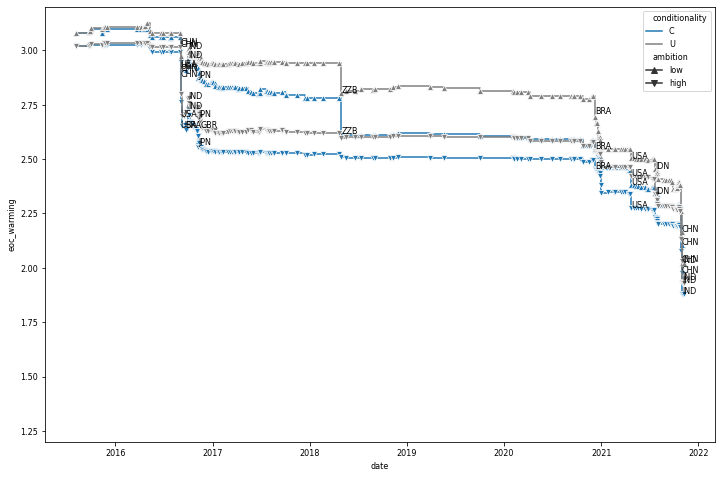

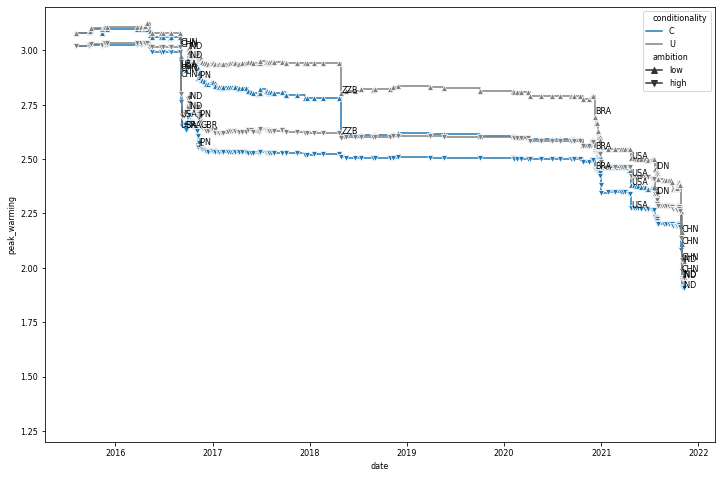

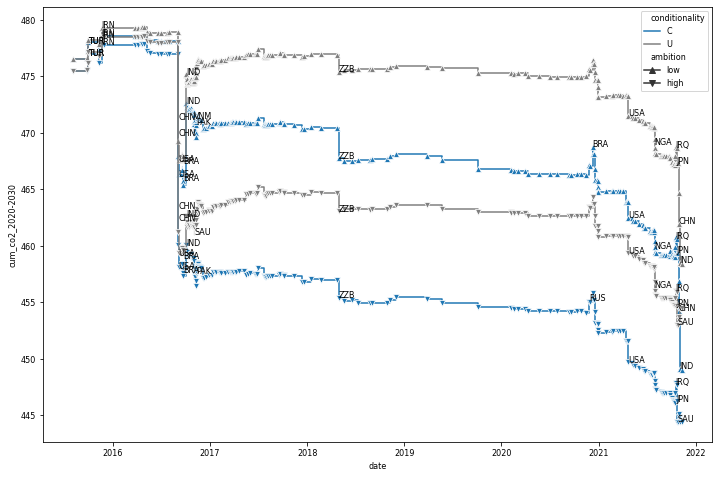

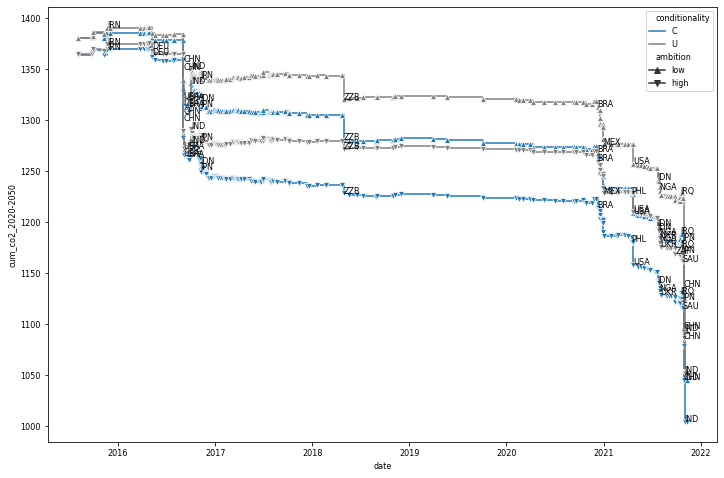

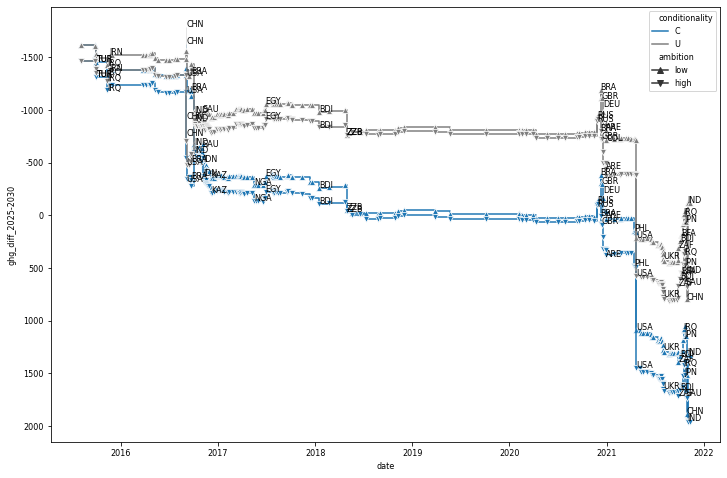

<IPython.core.display.Javascript object>

In [24]:
palette = {"high": "tab:blue", "low": "tab:orange", "U": "tab:grey", "C": "tab:blue"}

dashes = {"C": (3, 3), "U": "", "high": "", "low": ""}
markers = {"C": "o", "U": "o", "high": "v", "low": "^"}

threshold = {
    "eoc_warming": 0.04,
    "peak_warming": 0.04,
    "cum_co2_2020-2030": 1,
    "cum_co2_2020-2050": 5,
    "ghg_diff_2025-2030": 50,
}

for v in [
    "eoc_warming",
    "peak_warming",
    "cum_co2_2020-2030",
    "cum_co2_2020-2050",
    "ghg_diff_2025-2030",
]:
    plt.figure()
    # sns.scatterplot(data=df, x="date", y=v, hue="ambition", style="conditionality")

    ax = sns.lineplot(
        data=df,
        x="date",
        y=v,
        drawstyle="steps-post",
        hue="conditionality",
        palette=palette,
        style="ambition",
        dashes=dashes,
        markers=markers,
    )

    plot_steps(
        ambition="high",
        conditionality="U",
        variable=v,
        ax=plt.gca(),
        sensitivity=threshold[v],
    )
    plot_steps(
        ambition="low",
        conditionality="U",
        variable=v,
        ax=plt.gca(),
        sensitivity=threshold[v],
    )
    plot_steps(
        ambition="high",
        conditionality="C",
        variable=v,
        ax=plt.gca(),
        sensitivity=threshold[v],
    )
    plot_steps(
        ambition="low",
        conditionality="C",
        variable=v,
        ax=plt.gca(),
        sensitivity=threshold[v],
    )

    if v in ["ghg_diff_2025-2030"]:
        plt.gca().invert_yaxis()

    if v in ["peak_warming", "eoc_warming"]:
        ax.set_ylim(1.2, 3.2)

    # plot the last data points as bar.

    #     # Create a Rectangle patch
    #     rect = patches.Rectangle(
    #         ("1/1/2022", 1.5), 3, 0.25, linewidth=1, edgecolor="r", facecolor="none"
    #     )

    #     # Add the patch to the Axes
    #     ax.add_patch(rect)

    # ax.set_ylim(2015, 2023)

    out_file = f"Figure4_{v}_{NDC_TARGET_RELEASE}.pdf"
    plt.savefig(
        os.path.join(PROCESSED_DATA_DIR, "figures", out_file)
        transparent=True,
    )

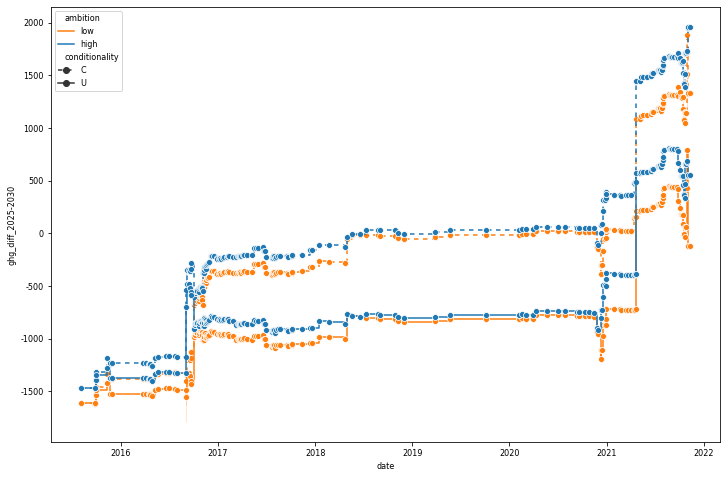

<IPython.core.display.Javascript object>

In [25]:
threshold = {
    "eoc_warming": 0.04,
    "peak_warming": 0.04,
    "cum_co2_2020-2030": 1,
    "cum_co2_2020-2050": 1,
    "ghg_diff_2025-2030": 50,
}

for v in [
    "ghg_diff_2025-2030",
]:
    plt.figure()
    # sns.scatterplot(data=df, x="date", y=v, hue="ambition", style="conditionality")

    ax = sns.lineplot(
        data=df,
        x="date",
        y=v,
        drawstyle="steps-post",
        hue="ambition",
        palette=palette,
        style="conditionality",
        dashes=dashes,
        markers=markers,
    )

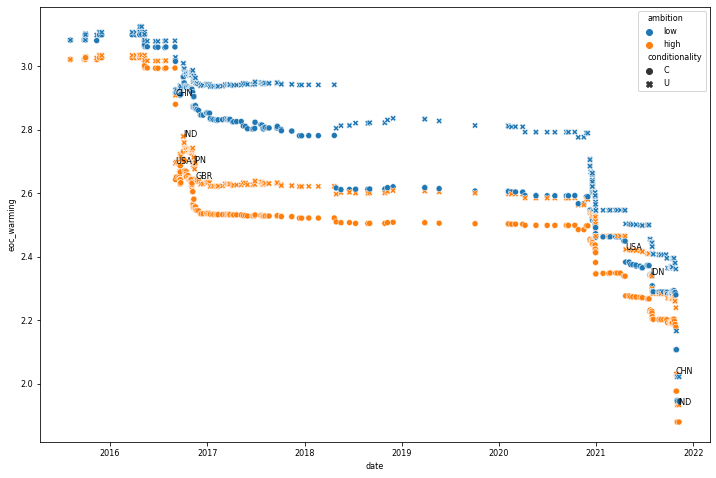

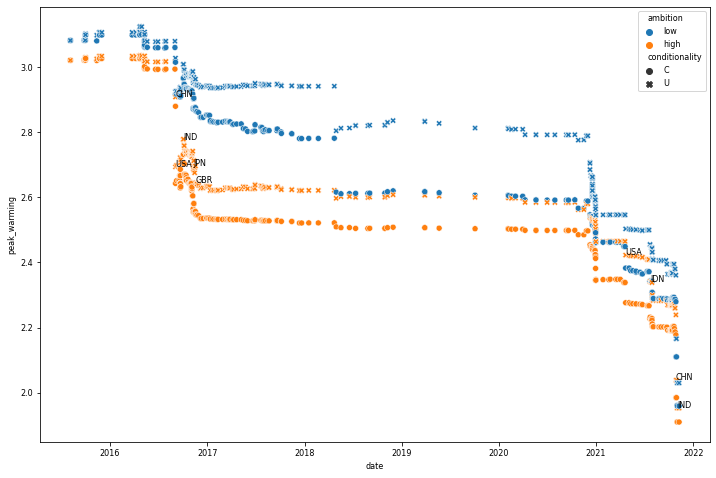

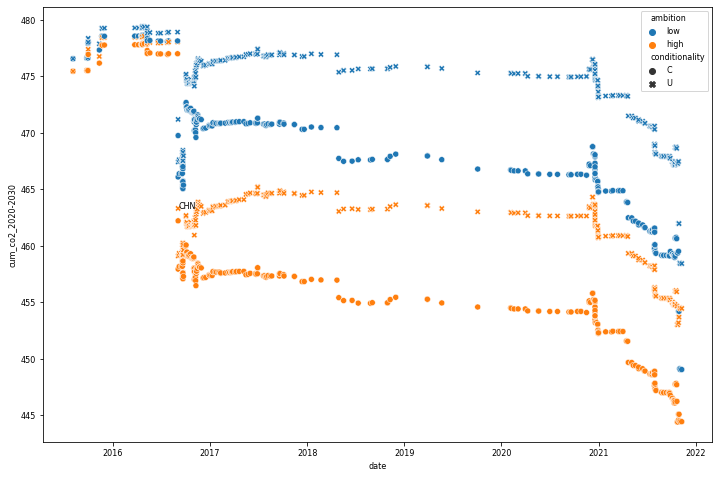

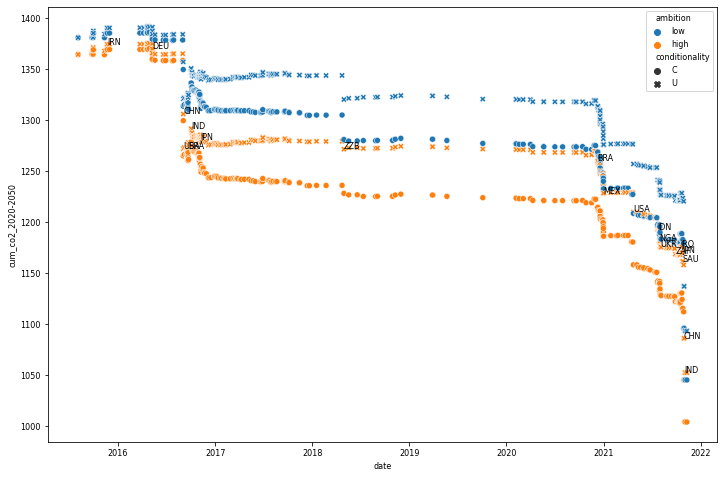

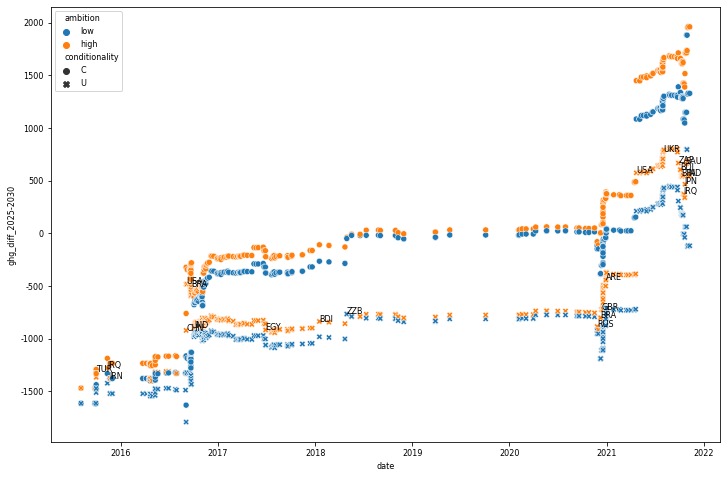

<IPython.core.display.Javascript object>

In [26]:
threshold = {
    "eoc_warming": 0.04,
    "peak_warming": 0.04,
    "cum_co2_2020-2030": 5,
    "cum_co2_2020-2050": 5,
    "ghg_diff_2025-2030": 50,
}

for v in [
    "eoc_warming",
    "peak_warming",
    "cum_co2_2020-2030",
    "cum_co2_2020-2050",
    "ghg_diff_2025-2030",
]:
    plt.figure()
    sns.scatterplot(data=df, x="date", y=v, hue="ambition", style="conditionality")

    plot_steps(
        ambition="high",
        conditionality="U",
        variable=v,
        ax=plt.gca(),
        sensitivity=threshold[v],
    )